In [1]:
# Let's investigate transforming y vars so that L2 minimization is close to minimizing smape.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

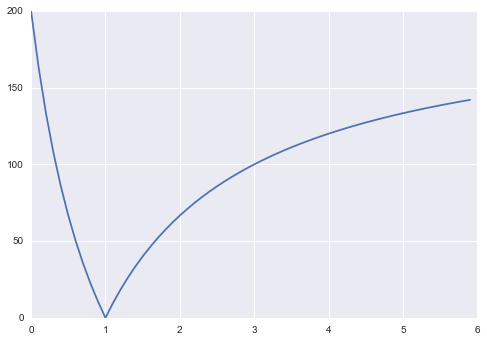

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [9]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

In [12]:
# Simple linear fit of mean of original data.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
model.fit(X_trainvalid, Y_trainvalid)
Y_predict = model.predict(X_test)
print('Smape = ', smape(Y_predict, Y_test))

Smape =  117.577692786


Smape =  160.786918542
param =  1 	Smape =  160.786918542param =  26 	Smape =  146.088817384param =  51 	Smape =  143.637991645param =  76 	Smape =  142.21872778param =  101 	Smape =  141.239407724param =  126 	Smape =  140.506912158param =  151 	Smape =  139.931399463param =  176 	Smape =  139.464300118param =  201 	Smape =  139.07534997param =  226 	Smape =  138.744432843param =  251 	Smape =  138.458121803param =  276 	Smape =  138.207191545param =  301 	Smape =  137.984954366param =  326 	Smape =  137.786366393param =  351 	Smape =  137.607556473param =  376 	Smape =  137.445513491param =  401 	Smape =  137.297849173param =  426 	Smape =  137.162626629param =  451 	Smape =  137.038250808param =  476 	Smape =  136.923399779param =  501 	Smape =  136.81697295param =  526 	Smape =  136.718047296param =  551 	Smape =  136.625840952param =  576 	Smape =  136.539684588param =  601 	Smape =  136.459000049param =  626 	Smape =  136.383284471param =  651 	Smape =  136.312097961param =  676 

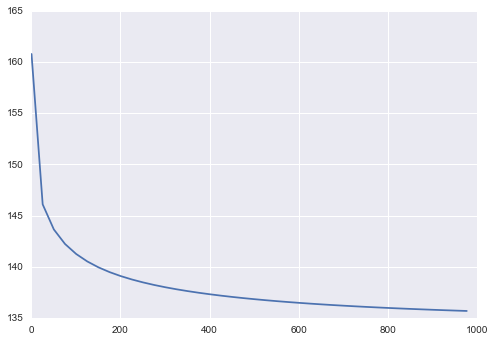

In [35]:
# Now let's try transforming the data.

def Ztransform(Y, param = 1.0):
    return 1 / (param + Y)

def invZtransform(Z, param = 1.0):
    return -param + 1 / Z

Z_train = Ztransform(Y_train)
Z_valid = Ztransform(Y_valid)
Z_test = Ztransform(Y_test)

model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = invZtransform(Z_predict)
print('Smape = ', smape(Y_predict, Y_valid))

# Now try varying param
param_search = np.arange(1, 1000, 25)
smapes = []
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    Z_test = Ztransform(Y_test, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

Smape =  147.398161288
param =  1 	Smape =  147.398161288param =  26 	Smape =  108.052268681param =  51 	Smape =  102.45594521param =  76 	Smape =  99.6397522922param =  101 	Smape =  97.8907173935param =  126 	Smape =  96.6951325837param =  151 	Smape =  95.8332377061param =  176 	Smape =  95.19162642param =  201 	Smape =  94.7044583323param =  226 	Smape =  94.3304429313param =  251 	Smape =  94.0421055824param =  276 	Smape =  93.8202949869param =  301 	Smape =  93.6511100997param =  326 	Smape =  93.52413657param =  351 	Smape =  93.4314178852param =  376 	Smape =  93.3667762331param =  401 	Smape =  93.3253385392param =  426 	Smape =  93.303208027param =  451 	Smape =  93.2972357292param =  476 	Smape =  93.3048545213param =  501 	Smape =  93.323953639param =  526 	Smape =  93.3527834431param =  551 	Smape =  93.389883164param =  576 	Smape =  93.4340252639param =  601 	Smape =  93.4841718177param =  626 	Smape =  93.5394401006param =  651 	Smape =  93.5990755037param =  676 	Smap

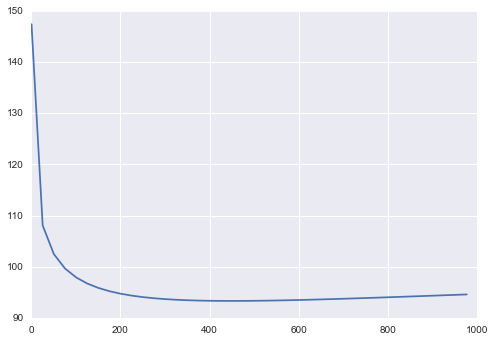

In [42]:
# Now let's try transforming the data. Transform the domain too.

def Ztransform(Y, param):
    return 1 / (param + Y)

def invZtransform(Z, param ):
    return -param + 1 / Z

Z_train = Ztransform(Y_train, 1.0)
Z_valid = Ztransform(Y_valid, 1.0)
Z_test = Ztransform(Y_test, 1.0)
X_train2 = Ztransform(X_train.mean(axis = 1, keepdims = True), 1.0)
X_valid2 = Ztransform(X_valid.mean(axis = 1, keepdims = True), 1.0)

model = LinearRegression()
model.fit(X_train2, Z_train)
Z_predict = model.predict(X_valid2)
Y_predict = invZtransform(Z_predict, 1.0)
print('Smape = ', smape(Y_predict, Y_valid))

# Now try varying param
param_search = np.arange(1, 1000, 25)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    X_train2 = Ztransform(X_train.mean(axis = 1, keepdims = True), param)
    X_valid2 = Ztransform(X_valid.mean(axis = 1, keepdims = True), param)
    
    model.fit(X_train2, Z_train)
    Z_predict = model.predict(X_valid2)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

Smape =  141.197520465
param =  1 	Smape =  141.197520465param =  26 	Smape =  138.2339046param =  51 	Smape =  137.363878636param =  76 	Smape =  136.847264938param =  101 	Smape =  136.488290291param =  126 	Smape =  136.218894574param =  151 	Smape =  136.007194055param =  176 	Smape =  135.835583507param =  201 	Smape =  135.69327839param =  226 	Smape =  135.573189408param =  251 	Smape =  135.4704301param =  276 	Smape =  135.38149916param =  301 	Smape =  135.303803163param =  326 	Smape =  135.235374071param =  351 	Smape =  135.174690151param =  376 	Smape =  135.120553888param =  401 	Smape =  135.072007551param =  426 	Smape =  135.028274829param =  451 	Smape =  134.98871979param =  476 	Smape =  134.952817331param =  501 	Smape =  134.920131651param =  526 	Smape =  134.890299691param =  551 	Smape =  134.863013345param =  576 	Smape =  134.837999133param =  601 	Smape =  134.815012039param =  626 	Smape =  134.793840198param =  651 	Smape =  134.774302973param =  676 	Sma

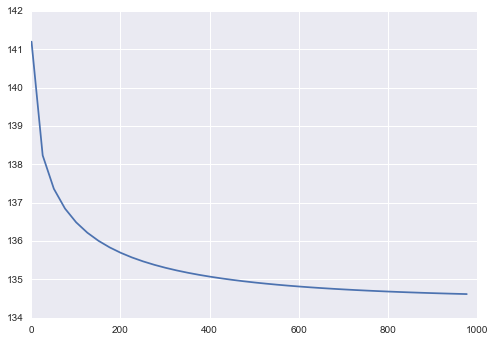

In [36]:
# Now let's try transforming the data.

def Ztransform(Y, param):
    return np.log(param + Y)

def invZtransform(Z, param):
    return -param + np.exp(Z)

Z_train = Ztransform(Y_train, 1.0)
Z_valid = Ztransform(Y_valid, 1.0)
Z_test = Ztransform(Y_test, 1.0)

model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = invZtransform(Z_predict, 1.0)
print('Smape = ', smape(Y_predict, Y_valid))

# Now try varying param
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
param_search = np.arange(1, 1000, 25)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    Z_test = Ztransform(Y_test, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

Smape =  199.941889243
param =  1 	Smape =  199.941889243param =  26 	Smape =  199.941783515param =  51 	Smape =  199.9417765param =  76 	Smape =  199.941773395param =  101 	Smape =  199.941771557param =  126 	Smape =  199.941770311param =  151 	Smape =  199.941769398param =  176 	Smape =  199.941768693param =  201 	Smape =  199.941768128param =  226 	Smape =  199.941767663param =  251 	Smape =  199.941767271param =  276 	Smape =  199.941766935param =  301 	Smape =  199.941766644param =  326 	Smape =  199.941766388param =  351 	Smape =  199.941766161param =  376 	Smape =  199.941765958param =  401 	Smape =  199.941765775param =  426 	Smape =  199.941765609param =  451 	Smape =  199.941765457param =  476 	Smape =  199.941765318param =  501 	Smape =  199.94176519param =  526 	Smape =  199.941765071param =  551 	Smape =  199.941764961param =  576 	Smape =  199.941764859param =  601 	Smape =  199.941764763param =  626 	Smape =  199.941764673param =  651 	Smape =  199.941764589param =  676 

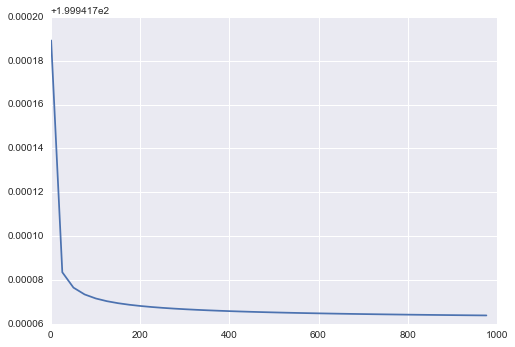

In [37]:
# Now let's try transforming the data.
epsilon = 1e-4
def Ztransform(Y, param):
    return np.sqrt(param + Y**2) / (epsilon + Y)

def invZtransform(Z, param):
    return np.sqrt(param / (Z**2 - 1))

Z_train = Ztransform(Y_train, 1.0)
Z_valid = Ztransform(Y_valid, 1.0)
Z_test = Ztransform(Y_test, 1.0)

model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = invZtransform(Z_predict, 1.0)
print('Smape = ', smape(Y_predict, Y_valid))

# Now try varying param
model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('linear', LinearRegression()) ])
param_search = np.arange(1, 1000, 25)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    Z_test = Ztransform(Y_test, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

smape =  111.662960934


C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


param =  1 	Smape =  nanparam =  26 	Smape =  97.5010743035param =  51 	Smape =  95.1390455663param =  76 	Smape =  93.9834659278param =  101 	Smape =  93.3002655782param =  126 	Smape =  92.8171124508param =  151 	Smape =  92.542814828param =  176 	Smape =  92.3410681357param =  201 	Smape =  92.1663236163param =  226 	Smape =  92.0097357478param =  251 	Smape =  92.0022890253param =  276 	Smape =  92.5535577995param =  301 	Smape =  93.8095723947param =  326 	Smape =  93.7490178531param =  351 	Smape =  94.3316856479param =  376 	Smape =  94.3745146606param =  401 	Smape =  97.3741203054param =  426 	Smape =  99.4671803339param =  451 	Smape =  99.4524644997param =  476 	Smape =  99.685269664param =  501 	Smape =  99.6885902023param =  526 	Smape =  99.8541265655param =  551 	Smape =  109.708337126param =  576 	Smape =  111.730358571param =  601 	Smape =  112.461382843param =  626 	Smape =  112.452495467param =  651 	Smape =  112.445225973param =  676 	Smape =  112.439404629param =  

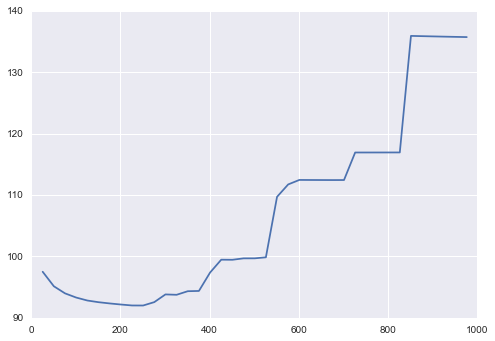

test smape =  nan


C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [52]:
# Let's look at non-parametric fits for just mean.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

# Now let's try fitting transform Z

def Ztransform(Y, param):
    return 1 / (param + Y)

def invZtransform(Z, param ):
    return -param + 1 / Z

# Now try varying param
param_search = np.arange(1, 1000, 25)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

# Now let's do a test.
Z_trainvalid = Ztransform(Y_trainvalid, param = 200)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = invZtransform(Z_predict, param = 200)
print('test smape = ', smape(Y_predict, Y_test))

In [56]:
# Now let's do a test.
Z_trainvalid = Ztransform(Y_trainvalid, param = 200)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = invZtransform(Z_predict, param = 200)
print('test smape = ', smape(Y_predict + 1e-6, Y_test))

test smape =  91.6905959899


smape =  111.662960934
param =  1 	Smape =  90.52939597param =  3 	Smape =  89.9924610748param =  5 	Smape =  89.6620655538param =  7 	Smape =  89.4890682203param =  9 	Smape =  89.5509109322param =  11 	Smape =  89.360669269param =  13 	Smape =  89.330954229param =  15 	Smape =  89.3229456297param =  17 	Smape =  89.3430644078param =  19 	Smape =  89.3324038789param =  21 	Smape =  89.3504599025param =  23 	Smape =  89.3677042178param =  25 	Smape =  89.4042689339param =  27 	Smape =  89.4242697325param =  29 	Smape =  89.409687455param =  31 	Smape =  89.4198145665param =  33 	Smape =  89.4561261186param =  35 	Smape =  89.4647648669param =  37 	Smape =  89.5548118783param =  39 	Smape =  89.5755732695

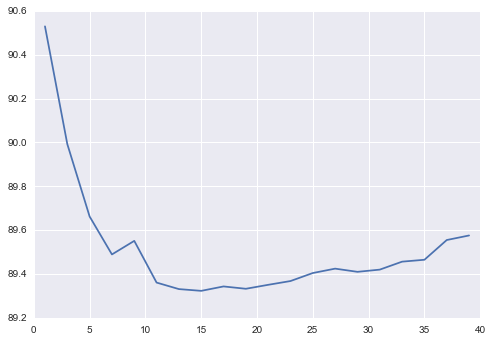

In [58]:
# Let's look at non-parametric fits for just mean.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

# Now let's try fitting transform Z

def Ztransform(Y, param):
    return np.log(param + Y)

def invZtransform(Z, param):
    return -param + np.exp(Z)

# Now try varying param
param_search = np.arange(1, 40, 2)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

In [59]:
# Now let's do a test.
Z_trainvalid = Ztransform(Y_trainvalid, param = 15)
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = invZtransform(Z_predict, param = 15)
print('test smape = ', smape(Y_predict + 1e-6, Y_test))

test smape =  88.6556121364


smape =  111.662960934


C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


param =  1 	Smape =  nanparam =  51 	Smape =  194.373206867param =  101 	Smape =  194.167968338param =  151 	Smape =  194.029415613param =  201 	Smape =  193.923173774param =  251 	Smape =  193.816362015param =  301 	Smape =  193.762788322param =  351 	Smape =  193.678718212param =  401 	Smape =  193.621883636param =  451 	Smape =  193.590679226param =  501 	Smape =  193.524227446param =  551 	Smape =  193.481524777param =  601 	Smape =  193.461931432param =  651 	Smape =  193.405294762param =  701 	Smape =  193.370927425param =  751 	Smape =  193.338635056param =  801 	Smape =  193.30817223param =  851 	Smape =  193.299197753param =  901 	Smape =  193.271811502param =  951 	Smape =  193.225881511

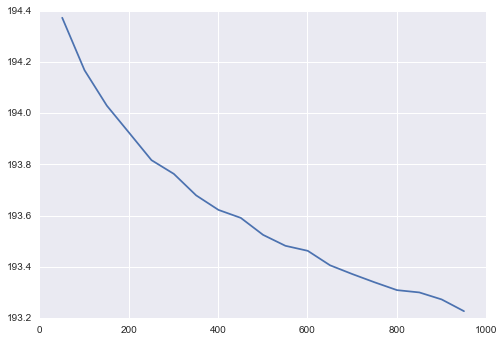

In [60]:
# Let's look at non-parametric fits for just mean.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

# Now let's try fitting transform Z

epsilon = 1e-4
def Ztransform(Y, param):
    return np.sqrt(param + Y**2) / (epsilon + Y)

def invZtransform(Z, param):
    return np.sqrt(param / (Z**2 - 1))

# Now try varying param
param_search = np.arange(1, 1000, 50)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

smape =  111.662960934
p =  1 0.01  Smape =  90.6729277861p =  26 0.01  Smape =  89.4186959068p =  51 0.01  Smape =  89.6491287374p =  76 0.01  Smape =  89.9489053469p =  101 0.01  Smape =  90.1704893165p =  126 0.01  Smape =  90.4099384806p =  151 0.01  Smape =  90.6095109741p =  176 0.01  Smape =  90.8653521972p =  1 0.06  Smape =  91.3099002456p =  26 0.06  Smape =  89.5554073907p =  51 0.06  Smape =  89.7121173085p =  76 0.06  Smape =  89.979264372p =  101 0.06  Smape =  90.1345095179p =  126 0.06  Smape =  90.3721599776p =  151 0.06  Smape =  90.5265041467p =  176 0.06  Smape =  90.7962020416p =  1 0.11  Smape =  91.9237013014p =  26 0.11  Smape =  89.7246047283p =  51 0.11  Smape =  89.7318924411p =  76 0.11  Smape =  89.9829899295p =  101 0.11  Smape =  90.162058614p =  126 0.11  Smape =  90.3776175718p =  151 0.11  Smape =  90.5624639759p =  176 0.11  Smape =  90.7308121121p =  1 0.16  Smape =  92.6787103687p =  26 0.16  Smape =  89.9461717818p =  51 0.16  Smape =  89.961666535

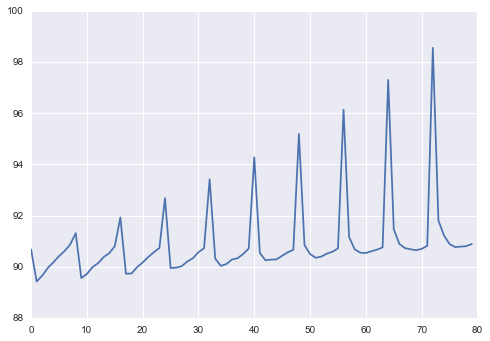

In [66]:
# Let's look at non-parametric fits for just mean. Let's vary power and offset.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

# Now let's try fitting transform Z

def Ztransform(Y, param1, param2):
    return 1 / (param1 + Y)**param2

def invZtransform(Z, param1, param2):
    return -param1 + 1 / Z**(1/param2)

# Now try varying param
param_search1 = np.arange(1, 200, 25)
param_search2 = np.arange(0.01, 0.5, 0.05)
param_search = [(x, y) for y in param_search2 for x in param_search1]
smapes = []
for param1, param2 in param_search:
    Z_train = Ztransform(Y_train, param1, param2)
    Z_valid = Ztransform(Y_valid, param1, param2)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param1, param2)
    newsmape = smape(1e-6+Y_predict, Y_valid)
    print('p = ', param1, param2, ' Smape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(smapes)
plt.show()


smape =  111.662960934
p2 =  0.01  Smape =  89.6390044591p2 =  0.03  Smape =  89.6308637007p2 =  0.05  Smape =  89.6811357547p2 =  0.07  Smape =  89.6847746885p2 =  0.09  Smape =  89.7722542647p2 =  0.11  Smape =  89.7698675214p2 =  0.13  Smape =  89.8461193694p2 =  0.15  Smape =  89.9137182236p2 =  0.17  Smape =  89.9215403136p2 =  0.19  Smape =  89.9668998961p2 =  0.21  Smape =  90.0283613251p2 =  0.23  Smape =  90.1277766669p2 =  0.25  Smape =  90.2144928193p2 =  0.27  Smape =  90.2941152256p2 =  0.29  Smape =  90.4163711704p2 =  0.31  Smape =  90.5078680219p2 =  0.33  Smape =  90.5954299737p2 =  0.35  Smape =  90.6470714535p2 =  0.37  Smape =  90.6960243452p2 =  0.39  Smape =  90.8000541218p2 =  0.41  Smape =  90.9033393233p2 =  0.43  Smape =  91.0549611597p2 =  0.45  Smape =  91.1860266895p2 =  0.47  Smape =  91.2945541293p2 =  0.49  Smape =  91.3712914703

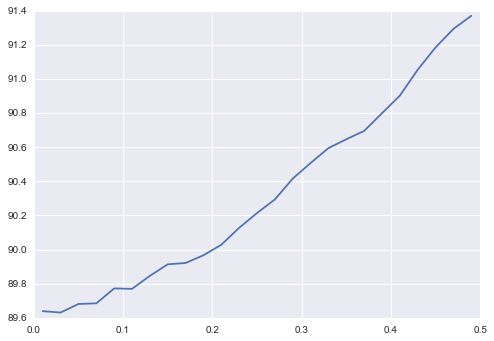

In [72]:
# Let's just vary the power.

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Y_train)
Y_predict = model.predict(X_valid)
print('smape = ', smape(Y_predict, Y_valid))

# Now let's try fitting transform Z

def Ztransform(Y, param1, param2):
    return 1 / (param1 + Y)**param2

def invZtransform(Z, param1, param2):
    return -param1 + 1 / Z**(1/param2)

# Now try varying param
param_search2 = np.arange(0.01, 0.5, 0.02)
smapes = []
for param2 in param_search2:
    Z_train = Ztransform(Y_train, param1 = 50, param2 = param2)
    Z_valid = Ztransform(Y_valid, param1 = 50, param2 = param2)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param1 = 50, param2 = param2)
    newsmape = smape(1e-6+Y_predict, Y_valid)
    print('p2 = ', param2, ' Smape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search2, smapes)
plt.show()


Y_mean =  1168.57086486
()


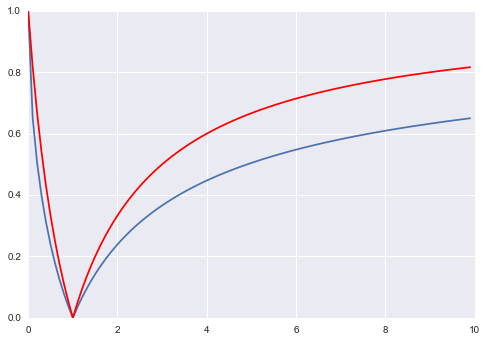

C:\Users\Matthew\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


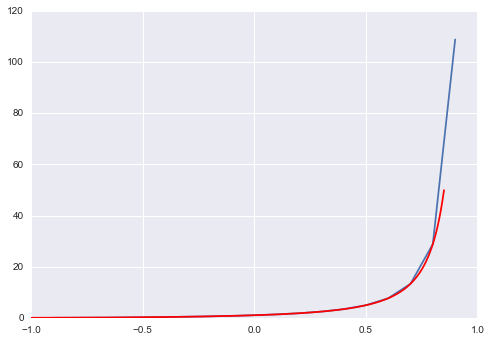

In [142]:
# Let's try plugging typical value of Y_actual into square root bound on SMAPE formula.

Y_mean = Y_train.mean()
print('Y_mean = ', Y_mean)

def Ztransform(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)
           
def invZtransform(Z, param):
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1
    result = param * result**2
    return result

domain = np.arange(0, 10, 0.1)
yvals1 = np.abs(Ztransform(domain, 1))
yvals2 = np.abs((1 - domain) / (1 + domain))
print(yvals3.shape)
plt.plot(domain, yvals1)
plt.plot(domain,  yvals2, color = 'red')
plt.show()

domain1 = np.arange(-1, 1, 0.1)
yvals1 = invZtransform(domain1, 1)
domain2 = np.arange(0, 50, 0.1)
yvals2 = Ztransform(domain2, 1)
plt.plot(domain1, yvals1)
plt.plot(yvals2, domain2, color = 'red')
plt.show()

param =  1 	Smape =  103.585288231param =  101 	Smape =  91.5125387081param =  201 	Smape =  90.5601249461param =  301 	Smape =  89.9716812206param =  401 	Smape =  89.656805832param =  501 	Smape =  89.452629811param =  601 	Smape =  89.3727063587param =  701 	Smape =  89.2656878227param =  801 	Smape =  89.0721176583param =  901 	Smape =  89.0047280111param =  1001 	Smape =  88.9010852826param =  1101 	Smape =  88.9077462021param =  1201 	Smape =  88.8786287148param =  1301 	Smape =  88.8922335849param =  1401 	Smape =  88.8485876787param =  1501 	Smape =  88.8104772961param =  1601 	Smape =  88.8247665924param =  1701 	Smape =  88.8039640648param =  1801 	Smape =  88.7965238416param =  1901 	Smape =  88.7610672804param =  2001 	Smape =  88.761461451param =  2101 	Smape =  88.7186083839param =  2201 	Smape =  88.6903692231param =  2301 	Smape =  88.6552624307param =  2401 	Smape =  88.6992048778

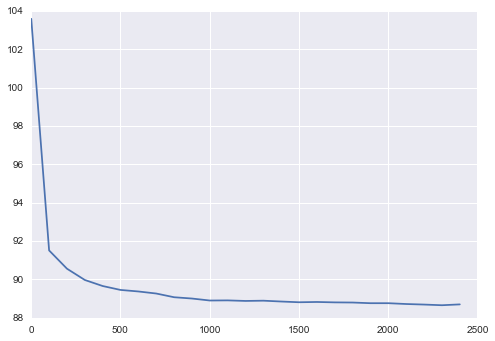

In [122]:

epsilon = 1e-6
def Ztransform(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)
           
def invZtransform(Z, param):
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1 + epsilon
    result = param * result**2
    return result

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

# Now try varying param
param_search = np.arange(1, 2500, 100)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    print('param = ', param, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

ps =  1 0.5 	Smape =  99.0641924654ps =  201 0.5 	Smape =  89.8803384734ps =  401 0.5 	Smape =  89.7155834966ps =  601 0.5 	Smape =  89.761951771ps =  801 0.5 	Smape =  89.7607355455ps =  1001 0.5 	Smape =  89.6533090016ps =  1201 0.5 	Smape =  89.6681774166ps =  1 0.6 	Smape =  99.553747047ps =  201 0.6 	Smape =  89.1466891838ps =  401 0.6 	Smape =  88.965100123ps =  601 0.6 	Smape =  88.9037795608ps =  801 0.6 	Smape =  88.9448397078ps =  1001 0.6 	Smape =  88.9210455254ps =  1201 0.6 	Smape =  88.9112567096ps =  1 0.7 	Smape =  100.368714901ps =  201 0.7 	Smape =  89.0765532891ps =  401 0.7 	Smape =  88.8292138022ps =  601 0.7 	Smape =  88.7008102783ps =  801 0.7 	Smape =  88.6432228829ps =  1001 0.7 	Smape =  88.5044295925ps =  1201 0.7 	Smape =  88.5361836659ps =  1 0.8 	Smape =  101.284769399ps =  201 0.8 	Smape =  89.2079137575ps =  401 0.8 	Smape =  88.8210579049ps =  601 0.8 	Smape =  88.6035459539ps =  801 0.8 	Smape =  88.5441267812ps =  1001 0.8 	Smape =  88.459991909ps =  

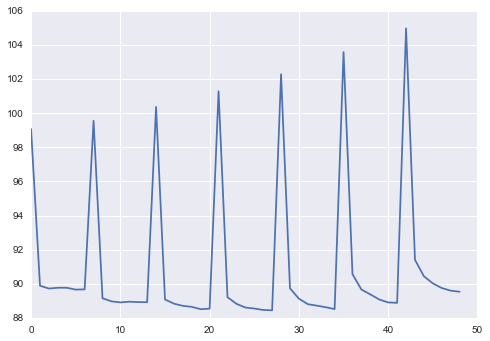

In [143]:

epsilon = 1e-6
def Ztransform(Y, param1, param2):
    return (np.sqrt(Y**param2) - np.sqrt(param1)) / np.sqrt(Y**param2 + param1)
           
def invZtransform(Z, param1, param2):
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1 + epsilon
    result = param1 * result**2
    result = result**(1/param2)
    return result

model = Pipeline([ ('mean', FunctionTransformer(lambda X : X.mean(axis = 1, keepdims = True))),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

# Now try varying param
param_search1 = np.arange(1, 1253, 200)
param_search2 = np.arange(0.5, 1.1, 0.1)
param_search = [(x,y) for y in param_search2 for x in param_search1]

smapes = []
for param1, param2 in param_search:
    Z_train = Ztransform(Y_train, param1, param2)
    Z_valid = Ztransform(Y_valid, param1, param2)
    
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = invZtransform(Z_predict, param1, param2)
    newsmape = smape(epsilon + Y_predict, Y_valid)
    print('ps = ', param1, param2, '\tSmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(smapes)
plt.show()

In [ ]:
# Let's look at average values of difference between smape(x,y) and z_transform(x) - z_transform(y) on a suitable domain x,y.

